In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import matplotlib.pyplot as plt
import json
%matplotlib inline


In [2]:
dataset = pd.read_json('SatCatdata.json')

In [3]:
dataset.head()

,INTLDES,NORAD_CAT_ID,OBJECT_TYPE,SATNAME,COUNTRY,LAUNCH,SITE,DECAY,PERIOD,INCLINATION,...,RCSVALUE,RCS_SIZE,FILE,LAUNCH_YEAR,LAUNCH_NUM,LAUNCH_PIECE,CURRENT,OBJECT_NAME,OBJECT_ID,OBJECT_NUMBER
0,2000-055PV,41715,DEBRIS,NOAA 16 DEB,US,2000-09-21,AFWTR,NaN,101.98,98.78,...,0,SMALL,6129,2000,55,PV,Y,NOAA 16 DEB,2000-055PV,41715
1,2000-055PS,41712,DEBRIS,NOAA 16 DEB,US,2000-09-21,AFWTR,NaN,101.97,98.89,...,0,SMALL,6129,2000,55,PS,Y,NOAA 16 DEB,2000-055PS,41712
2,1965-027M,14515,DEBRIS,OPS 4682 DEB,US,1965-04-03,AFWTR,NaN,111.09,90.30,...,0,SMALL,6108,1965,27,M,Y,OPS 4682 DEB,1965-027M,14515
3,1978-026JD,37642,DEBRIS,DELTA 1 DEB,US,1978-03-05,AFWTR,NaN,96.29,98.12,...,0,SMALL,6123,1978,26,JD,Y,DELTA 1 DEB,1978-026JD,37642
4,1961-015LW,18651,DEBRIS,THOR ABLESTAR DEB *,US,1961-06-29,AFETR,NaN,116.10,65.70,...,0,SMALL,6113,1961,15,LW,Y,THOR ABLESTAR DEB *,1961-015LW,18651


In [4]:
dataset.drop(['COMMENT'], axis=1)
dataset.drop(['COMMENTCODE'], axis=1)
dataset.columns

Index(['INTLDES', 'NORAD_CAT_ID', 'OBJECT_TYPE', 'SATNAME', 'COUNTRY',
       'LAUNCH', 'SITE', 'DECAY', 'PERIOD', 'INCLINATION', 'APOGEE', 'PERIGEE',
       'COMMENT', 'COMMENTCODE', 'RCSVALUE', 'RCS_SIZE', 'FILE', 'LAUNCH_YEAR',
       'LAUNCH_NUM', 'LAUNCH_PIECE', 'CURRENT', 'OBJECT_NAME', 'OBJECT_ID',
       'OBJECT_NUMBER'],
      dtype='object')

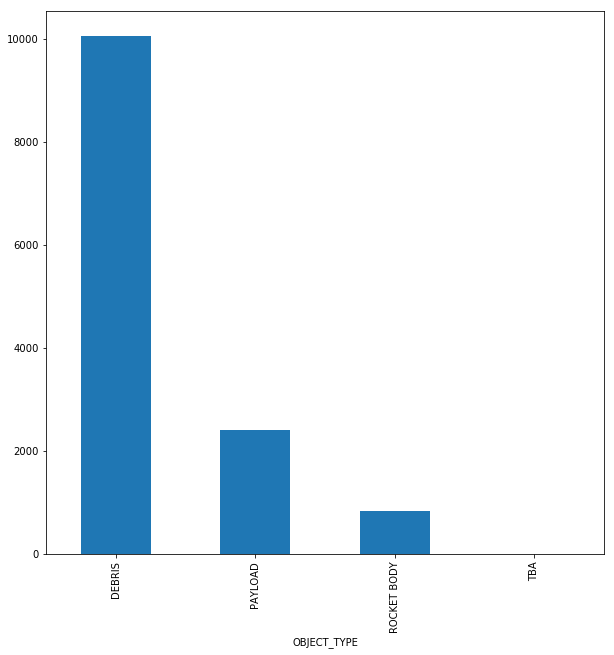

In [384]:
dfobjects = dataset.groupby(['OBJECT_TYPE'])['OBJECT_TYPE'].count()
dfobjects.plot(kind='bar')

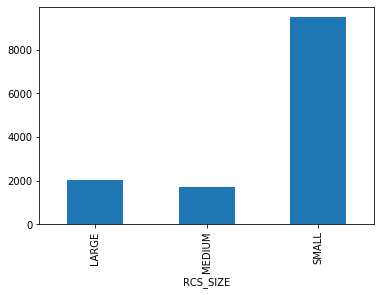

In [5]:
dfobjects = dataset.groupby(['RCS_SIZE'])['RCS_SIZE'].count()
dfobjects.plot(kind='bar')

In [22]:
# get the data  for the RCS, mean orbit speed
# clus_data = pd.concat([dataset.RCS_SIZE,dataset.OBJECT_TYPE, orbit_speed], axis=1
# clus_data = pd.concat([dataset.RCS_SIZE,dataset.INCLINATION, orbit_speed], axis=1)

clus_data = pd.concat([dataset.RCS_SIZE, orbit_speed], axis=1)

clus_data.head()


,RCS_SIZE,orbit_speed
0,SMALL,0.875403
1,SMALL,0.874975
2,SMALL,1.203773
3,SMALL,0.631864
4,SMALL,1.357929


In [7]:
# 3 sizes small, medium, large
# 4 types, (debris, payload, body)
clus_data = pd.concat([dataset.RCS_SIZE, dataset.OBJECT_TYPE], axis=1)

clus_data.head()

,RCS_SIZE,OBJECT_TYPE
0,SMALL,DEBRIS
1,SMALL,DEBRIS
2,SMALL,DEBRIS
3,SMALL,DEBRIS
4,SMALL,DEBRIS


In [35]:
clus_data.loc[clus_data['OBJECT_TYPE'] == 'TBA'].count()

RCS_SIZE       12
OBJECT_TYPE    12
dtype: int64

In [37]:
one_hot_obj = pd.get_dummies(clus_data)
one_hot_obj.tail()

,RCS_SIZE_LARGE,RCS_SIZE_MEDIUM,RCS_SIZE_SMALL,OBJECT_TYPE_DEBRIS,OBJECT_TYPE_PAYLOAD,OBJECT_TYPE_ROCKET BODY,OBJECT_TYPE_TBA
13294,0,1,0,0,1,0,0
13295,0,1,0,0,1,0,0
13296,0,1,0,0,1,0,0
13297,0,1,0,0,0,1,0
13298,0,1,0,0,1,0,0


In [399]:
obj = pd.concat([dataset.OBJECT_TYPE, orbit_speed], axis=1)
obj_labl = pd.get_dummies(obj[['OBJECT_TYPE', 'orbit_speed']])

obj_labl.head()

,orbit_speed,OBJECT_TYPE_DEBRIS,OBJECT_TYPE_PAYLOAD,OBJECT_TYPE_ROCKET BODY,OBJECT_TYPE_TBA
0,0.875403,1,0,0,0
1,0.874975,1,0,0,0
2,1.203773,1,0,0,0
3,0.631864,1,0,0,0
4,1.357929,1,0,0,0


In [42]:
from sklearn import tree
cls = tree.DecisionTreeClassifier()
cls.fit(pd.get_dummies(dataset['OBJECT_TYPE'][0:2000]), pd.get_dummies(dataset['RCS_SIZE'][0:2000]))


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [44]:
cls.score(pd.get_dummies(dataset['OBJECT_TYPE'][2000:4000]), pd.get_dummies(dataset['RCS_SIZE'][2000:4000]))

0.715

In [389]:
# Split into training and test data
# X = dataset.RCS_SIZE

# labl_data = pd.get_dummies(clus_data[['RCS_SIZE', 'orbit_speed']])
labl_data = pd.get_dummies(clus_data[['RCS_SIZE','orbit_speed']])

# Y = orbit_speed
labl_data.head()

,orbit_speed,RCS_SIZE_LARGE,RCS_SIZE_MEDIUM,RCS_SIZE_SMALL
0,0.875403,0,0,1
1,0.874975,0,0,1
2,1.203773,0,0,1
3,0.631864,0,0,1
4,1.357929,0,0,1


In [3]:
decay_data = pd.read_csv('Satcat.csv')

In [4]:
decay_data.head()

,INTLDES,NORAD_CAT_ID,OBJECT_TYPE,SATNAME,COUNTRY,LAUNCH,SITE,DECAY,PERIOD,INCLINATION,...,RCSVALUE,RCS_SIZE,FILE,LAUNCH_YEAR,LAUNCH_NUM,LAUNCH_PIECE,CURRENT,OBJECT_NAME,OBJECT_ID,OBJECT_NUMBER
0,1957-001A,1,ROCKET BODY,SL-1 R/B,CIS,1957-10-04,TTMTR,1957-12-01,96.19,65.10,...,0,LARGE,1,1957,1,A,Y,SL-1 R/B,1957-001A,1
1,1957-001B,2,PAYLOAD,SPUTNIK 1,CIS,1957-10-04,TTMTR,1958-01-03,96.10,65.00,...,0,NaN,7179,1957,1,B,Y,SPUTNIK 1,1957-001B,2
2,1957-002A,3,PAYLOAD,SPUTNIK 2,CIS,1957-11-03,TTMTR,1958-04-14,103.74,65.33,...,0,SMALL,5922,1957,2,A,Y,SPUTNIK 2,1957-002A,3
3,1958-001A,4,PAYLOAD,EXPLORER 1,US,1958-02-01,AFETR,1970-03-31,88.48,33.15,...,0,NaN,1,1958,1,A,Y,EXPLORER 1,1958-001A,4
4,1958-002B,5,PAYLOAD,VANGUARD 1,US,1958-03-17,AFETR,NaN,132.74,34.24,...,0,MEDIUM,7211,1958,2,B,Y,VANGUARD 1,1958-002B,5


In [6]:
decay_data.columns

Index(['INTLDES', 'NORAD_CAT_ID', 'OBJECT_TYPE', 'SATNAME', 'COUNTRY',
       'LAUNCH', 'SITE', 'DECAY', 'PERIOD', 'INCLINATION', 'APOGEE', 'PERIGEE',
       'COMMENT', 'COMMENTCODE', 'RCSVALUE', 'RCS_SIZE', 'FILE', 'LAUNCH_YEAR',
       'LAUNCH_NUM', 'LAUNCH_PIECE', 'CURRENT', 'OBJECT_NAME', 'OBJECT_ID',
       'OBJECT_NUMBER'],
      dtype='object')

In [5]:
decay_data.drop(['NORAD_CAT_ID','COUNTRY', 'SITE', 'LAUNCH_NUM', 'LAUNCH_PIECE','COMMENTCODE', 'FILE','OBJECT_NUMBER','COMMENT'], axis=1)


,INTLDES,OBJECT_TYPE,SATNAME,LAUNCH,DECAY,PERIOD,INCLINATION,APOGEE,PERIGEE,RCSVALUE,RCS_SIZE,LAUNCH_YEAR,CURRENT,OBJECT_NAME,OBJECT_ID
0,1957-001A,ROCKET BODY,SL-1 R/B,1957-10-04,1957-12-01,96.19,65.10,938.0,214.0,0,LARGE,1957,Y,SL-1 R/B,1957-001A
1,1957-001B,PAYLOAD,SPUTNIK 1,1957-10-04,1958-01-03,96.10,65.00,1080.0,64.0,0,NaN,1957,Y,SPUTNIK 1,1957-001B
2,1957-002A,PAYLOAD,SPUTNIK 2,1957-11-03,1958-04-14,103.74,65.33,1659.0,211.0,0,SMALL,1957,Y,SPUTNIK 2,1957-002A
3,1958-001A,PAYLOAD,EXPLORER 1,1958-02-01,1970-03-31,88.48,33.15,215.0,183.0,0,NaN,1958,Y,EXPLORER 1,1958-001A
4,1958-002B,PAYLOAD,VANGUARD 1,1958-03-17,NaN,132.74,34.24,3833.0,650.0,0,MEDIUM,1958,Y,VANGUARD 1,1958-002B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45168,2017-052D,PAYLOAD,USA 296,2017-09-07,NaN,NaN,NaN,NaN,NaN,0,NaN,2017,Y,USA 296,2017-052D
45169,2017-052E,PAYLOAD,USA 297,2017-09-07,NaN,NaN,NaN,NaN,NaN,0,NaN,2017,Y,USA 297,2017-052E
45170,2013-076AD,DEBRIS,COSMOS 2491 DEB,2013-12-25,NaN,114.46,82.46,1498.0,1363.0,0,NaN,2013,Y,COSMOS 2491 DEB,2013-076AD
45171,2013-076AE,DEBRIS,COSMOS 2491 DEB,2013-12-25,NaN,114.99,82.47,1509.0,1401.0,0,NaN,2013,Y,COSMOS 2491 DEB,2013-076AE


In [6]:
decay_pred = pd.concat([decay_data['PERIOD'], decay_data['APOGEE'], decay_data['PERIGEE'], decay_data['INCLINATION'], decay_data.OBJECT_TYPE, decay_data.RCS_SIZE,decay_data.LAUNCH, decay_data.DECAY],axis=1).dropna()
decay_pred

,PERIOD,APOGEE,PERIGEE,INCLINATION,OBJECT_TYPE,RCS_SIZE,LAUNCH,DECAY
0,96.19,938.0,214.0,65.10,ROCKET BODY,LARGE,1957-10-04,1957-12-01
2,103.74,1659.0,211.0,65.33,PAYLOAD,SMALL,1957-11-03,1958-04-14
7,88.43,255.0,139.0,65.06,PAYLOAD,LARGE,1958-05-15,1960-04-06
16,718.96,40215.0,198.0,47.10,ROCKET BODY,SMALL,1959-08-07,1961-06-30
22,89.24,249.0,225.0,50.27,ROCKET BODY,MEDIUM,1959-10-13,1989-07-16
...,...,...,...,...,...,...,...,...
44820,87.84,182.0,153.0,51.62,DEBRIS,MEDIUM,2019-12-05,2019-12-13
44821,87.88,184.0,155.0,51.64,DEBRIS,MEDIUM,2019-12-05,2019-12-13
44824,87.62,170.0,143.0,96.98,ROCKET BODY,LARGE,2019-12-06,2019-12-18
44832,87.43,151.0,143.0,51.65,ROCKET BODY,LARGE,2019-12-06,2019-12-10


In [18]:
decay = pd.to_datetime(decay_pred['DECAY'])
launch = pd.to_datetime(decay_pred['LAUNCH'])


In [23]:
import time
time.mktime(decay)
# Convert pandas datetime to unix time


TypeError: Tuple or struct_time argument required